# Imports

In [16]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import pandas as pd
from datetime import datetime 
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import pickle
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from arch import arch_model

In [17]:
warnings.filterwarnings('ignore')

# Getting Data

In [18]:
ticker = yf.Ticker('tsla')
df = ticker.history(interval='1d', start='2010-01-01', end='2023-01-01')

# Creating dummy date index to prevent frequency warnings/errors (missing value imputation not necessary because there should
# be no data on days the market is not open)
dummy_dates = pd.date_range(end=datetime.today(), periods=len(df))
df['Dummy Date'] = dummy_dates.date
df.index = df.index.tz_convert(None)
df = df.reset_index()
df = df.set_index('Dummy Date')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
Dummy Date,,,,,,,,
2014-09-05,2010-06-29 04:00:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2014-09-06,2010-06-30 04:00:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2014-09-07,2010-07-01 04:00:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2014-09-08,2010-07-02 04:00:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2014-09-09,2010-07-06 04:00:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3150 entries, 2014-09-05 to 2023-04-20
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3150 non-null   datetime64[ns]
 1   Open          3150 non-null   float64       
 2   High          3150 non-null   float64       
 3   Low           3150 non-null   float64       
 4   Close         3150 non-null   float64       
 5   Volume        3150 non-null   int64         
 6   Dividends     3150 non-null   float64       
 7   Stock Splits  3150 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 221.5+ KB


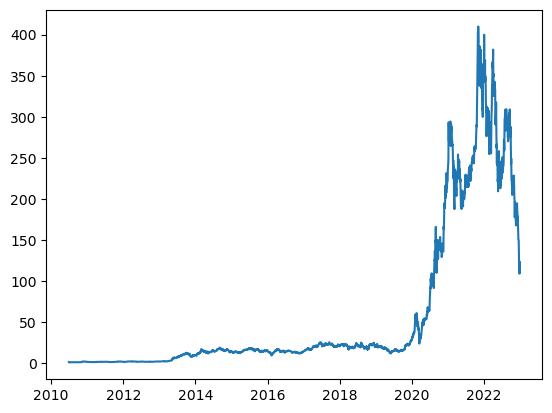

In [20]:
plt.plot(df['Date'], df['Close'])
plt.show()

# Stationarity

In [21]:
result = adfuller(df['Close'])
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -1.3620741719563567
ADF P-value: 0.6003172217845602


Based on the p-value of the ADF test, we fail to reject the null hypothesis and therefore, the data is not stationary.

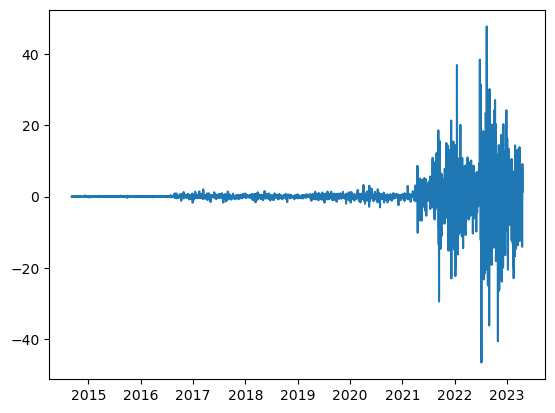

In [22]:
returns = df['Close'].diff().dropna()
plt.plot(returns)
plt.show()

In [23]:
result = adfuller(returns)
print('ADF Test Statistic: {}'.format(result[0]))
print('ADF P-value: {}'.format(result[1]))

ADF Test Statistic: -9.882055531868586
ADF P-value: 3.74738815394389e-17


By taking the first difference of the closing price, we see that the resulting p-value of the ADF test is now less than 0.05, so we can reject the null hypothesis and conclude that the returns are stationary. We also can conlude that the parameter, d, corresponding to the integrated component of our SARIMA model should be set to 1.

# Splitting Train/Test Data

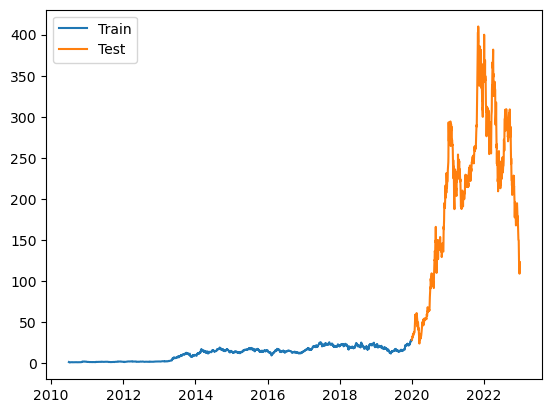

In [24]:
max_date = df.loc[df['Date'] < datetime(2020, 1, 1)].index.max()
max_train_idx = df.index.get_loc(max_date)
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='Train')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='Test')
plt.legend()
plt.show()

# PACF and ACF Plots

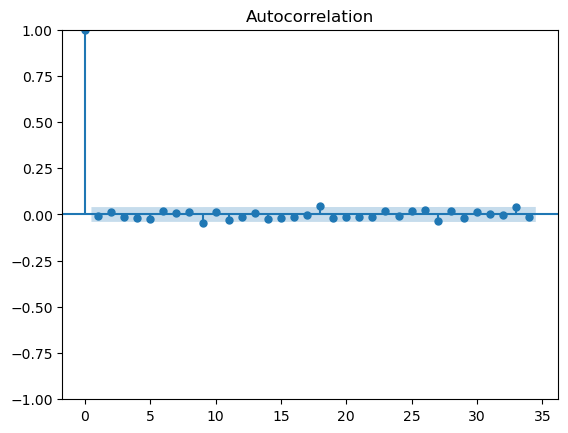

In [25]:
plot_acf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna())
plt.show()

Based on the ACF plot, possible values of the moving average (MA) component of the model could be {9}

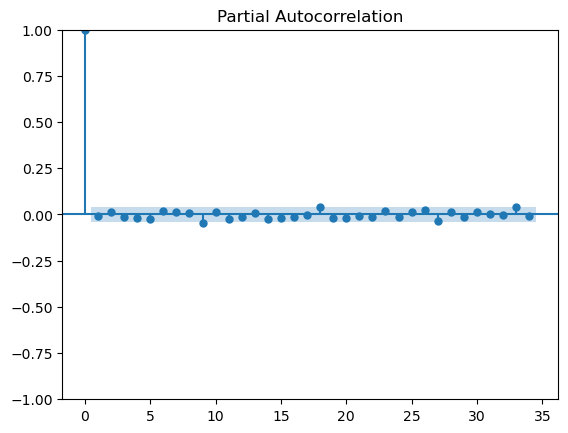

In [26]:
plot_pacf(df.iloc[:max_train_idx + 1]['Close'].diff().dropna(), method='ywm')
plt.show()

Based on the PACF plot, possible values of the autoregressive (AR) component of the model could be {9}

# ARIMA Parameter Tuning

In [27]:
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(9, 1, 9), missing='raise', freq='D')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2394
Model:                 ARIMA(9, 1, 9)   Log Likelihood               -1295.038
Date:                Thu, 20 Apr 2023   AIC                           2628.076
Time:                        20:55:33   BIC                           2737.902
Sample:                    09-05-2014   HQIC                          2668.036
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2844      0.384     -0.741      0.458      -1.036       0.467
ar.L2          0.4061      0.336      1.207      0.227      -0.253       1.065
ar.L3          0.3301      0.472      0.700      0.4

We see that the only coefficients that are significant are the 9th coefficent of both the AR and MA components, so we will optimize an ARIMA (9, 1, 9) model with only the 9th lag for both the AR and MA components.

# ARIMA (9, 1, 9) Model

In [28]:
lags = [0 if x != 8 else 1 for x in range(9)]
model = ARIMA(df.iloc[:max_train_idx + 1]['Close'], order=(lags, 1, lags), missing='raise', freq='D')
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2394
Model:             ARIMA([9], 1, [9])   Log Likelihood               -1302.586
Date:                Thu, 20 Apr 2023   AIC                           2611.172
Time:                        20:55:41   BIC                           2628.513
Sample:                    09-05-2014   HQIC                          2617.482
                         - 03-25-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L9         -0.5410      0.191     -2.833      0.005      -0.915      -0.167
ma.L9          0.4919      0.197      2.494      0.013       0.105       0.878
sigma2         0.1739      0.002     81.879      0.0

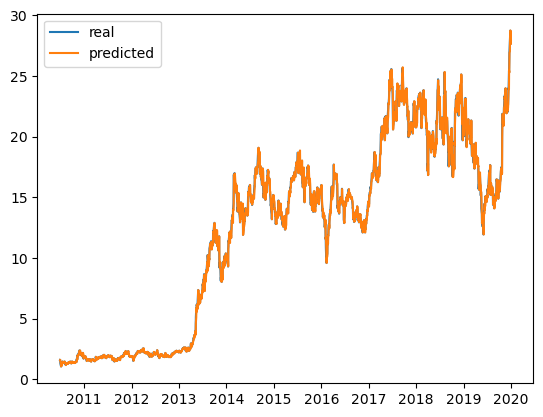

In [29]:
plt.plot(df.iloc[:max_train_idx + 1]['Date'], df.iloc[:max_train_idx + 1]['Close'], label='real')
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], results.fittedvalues[1:], label='predicted')
plt.legend()
plt.show()

In [30]:
# Train Results
mse = mean_squared_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mae = mean_absolute_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
mape = mean_absolute_percentage_error(df.iloc[1:max_train_idx + 1]['Close'], results.fittedvalues[1:])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

MSE: 0.17390791070649114
RMSE: 0.4170226740915788
MAE: 0.25373080182802055
MAPE: 0.022257617302402513


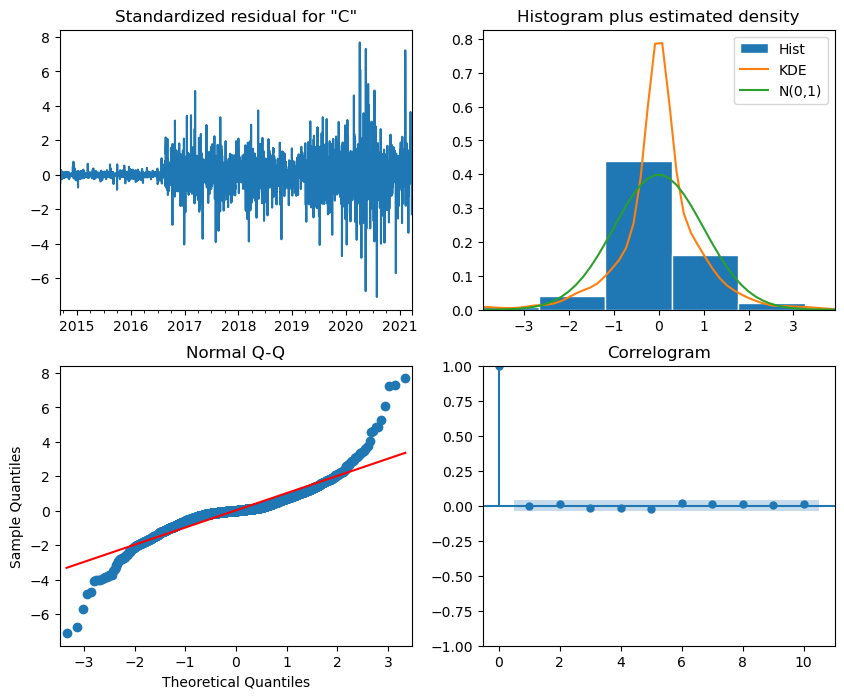

In [31]:
fig = plt.figure(figsize=(10, 8))
results.plot_diagnostics(fig=fig)
plt.show()

Based on the diagnostic plots, the residuals do appear to be normally distributed with mean 0 and do not appear to be correlated. However, it is clear that there is a change in volatility over time -> heteroskedasticity. To confirm these conclusions, we run an Ljung-Box test to check for autocorrelation and a Breusch Pagan test to check for heteroskedasticity. 

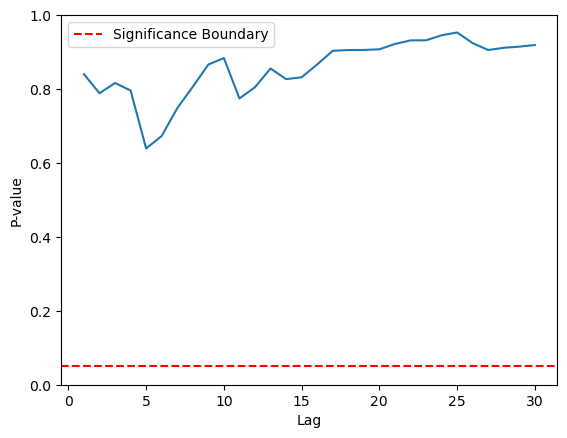

In [32]:
# Use Ljung-Box to statistically test for autocorrelation of residuals in the first 30 lags
resid_test = acorr_ljungbox(results.resid, lags=30, return_df=True)
plt.plot(resid_test['lb_pvalue'])
plt.axhline(0.05, linestyle='--', color='red', label='Significance Boundary')
plt.legend()
plt.ylim([0, 1])
plt.ylabel('P-value')
plt.xlabel('Lag')
plt.show()

The null hypothesis of the Ljung-Box test is that the residuals are independently distributed. Based on the figure above, we fail to reject the null hypothesis for the first 30 lags and conclude that the residuals are independently distributed (i.e. they do not exhibit serial correlation).

In [33]:
# Breusch-Pagan test for heteroskedasticity
n = len(df.iloc[1:max_train_idx + 1]) 
exog = np.zeros((n, 2))
exog[:, 0], exog[:, 1] = df.iloc[1:max_train_idx + 1]['Date'], df.iloc[1:max_train_idx + 1]['Close']

bp_test = het_breuschpagan(results.resid[1:], exog)
print('BP Test Statistic: {}'.format(bp_test[0]))
print('BP P-value: {}'.format(bp_test[1]))

BP Test Statistic: 19.39325093062492
BP P-value: 1.063823502087576e-05


Based on the results of the Breusch Pagan test, we reject the null hypothesis that the residuals are homoskedastic and conclude that there is a change in variance/volatility over time. To model this volatility we will use a GARCH model.

# Rolling Forecast Origin

In [ ]:
predictions = results.fittedvalues.to_list()

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    model = SARIMAX(df.iloc[i:max_train_idx + 1 + i]['Close'], order=(lags, 1, lags), initialization='approximate_diffuse').fit(
                                                    maxiter=200)
    
    # Forecast
    forecast = model.forecast()[0]
    predictions.append(forecast)

df['Close Predictions'] = predictions

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close'], label='real')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Close Predictions'], label='predicted')
plt.legend()
plt.show()

In [ ]:
# Test Results
mse = mean_squared_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mae = mean_absolute_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
mape = mean_absolute_percentage_error(df.iloc[max_train_idx + 1:]['Close'], df.iloc[max_train_idx + 1:]['Close Predictions'])
rmse = np.sqrt(mse)

print('MSE: {}\nRMSE: {}\nMAE: {}\nMAPE: {}'.format(mse, rmse, mae, mape))

# Modeling Volatility

In [ ]:
returns = 100 * df.iloc[:max_train_idx + 1]['Close'].pct_change().dropna()

plt.figure(figsize=(13, 4))
plt.plot(df.iloc[1:max_train_idx + 1]['Date'], returns)
plt.title('TSLA Returns')
plt.show()

In [ ]:
# PACF to determine order of AR component
plot_pacf(returns ** 2)
plt.show()

In [ ]:
# ACF to determine order of MA component
plot_acf(returns ** 2)
plt.show()

Based on the acf/pacf plots, possible orders of the MA component include {1, 2} and possible orders of the AR component include {1, 2}.

In [ ]:
# GARCH(2, 2)
model_fit = arch_model(returns, p=2, q=2, vol='Garch').fit()

In [ ]:
model_fit.summary()

From the model summary, we can see that none of the coefficients are statistically significant, so we can try a GARCH (1, 1) model instead.

In [ ]:
# GARCH (1, 1)
model_fit = arch_model(returns, p=1, q=1, vol='Garch').fit()

In [ ]:
model_fit.summary()

Now we see that the majority of coeficients are statistically significant and are ready to evaluate the model on the test data using a rolling forecast origin.

In [ ]:
# Rolling Forecast Origin
vol_preds = [np.nan for _ in range(max_train_idx + 1)] # pad training data with nan values because we only predict on test set

tqdm._instances.clear()
for i in tqdm(range(len(df) - max_train_idx - 1)):
    
    # Train the model
    returns = 100 * df.iloc[i:i + max_train_idx + 1]['Close'].pct_change().dropna()
    model_fit = arch_model(returns, p=1, q=1, vol='Garch').fit(disp='off')
    
    # Forecast
    forecast = model_fit.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1][0])
    vol_preds.append(vol)

df['Volatility Predictions'] = vol_preds

In [ ]:
plt.figure(figsize=(10, 4))
true_returns = 100 * df.iloc[max_train_idx + 1:]['Close'].pct_change().dropna()
plt.plot(df.iloc[max_train_idx + 2:]['Date'], true_returns, label='True Returns')
plt.plot(df.iloc[max_train_idx + 1:]['Date'], df.iloc[max_train_idx + 1:]['Volatility Predictions'], 
         label='Predicted Volatility')
plt.legend()
plt.show()

We see that the model is able to predict the volatility of the stock's returns.

In [ ]:
# Saving Data
df = df.set_index('Date')
df['Returns'] = 100 * df['Close'].pct_change()
df['Test Marker'] = [np.nan if x != max_train_idx + 1 else 'Start of Test Data' for x in range(len(df))]
df.to_csv('Processed Tesla Data.csv')